# Tesseract example

In [34]:
import pytesseract
print(pytesseract.__version__)

from PIL import Image
import imutils
import os
import time
from matplotlib import pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)

0.3.9


In [3]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [4]:
IMAGE_PATH = 'input/03.png'

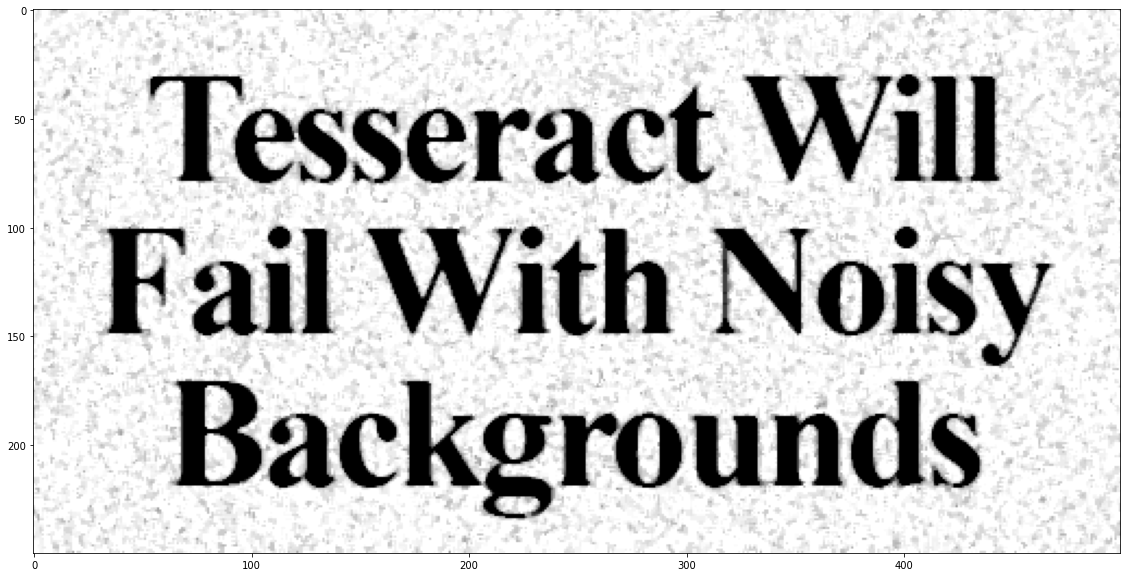

In [5]:
# load the example image and convert it to grayscale
image = cv2.imread(IMAGE_PATH)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.medianBlur(gray, 3)
filename = "{}.png".format(os.getpid())
cv2.imwrite(filename, gray)
plt.imshow(gray, cmap = 'gray')

In [6]:
text = pytesseract.image_to_string(Image.open(filename))
os.remove(filename)
print(text)

Tesseract Will
Fail With Noisy
Backgrounds



# Reference
Using Tesseract OCR with Python by Adrian Rosebrock on July 10, 2017, https://pyimagesearch.com/2017/07/10/using-tesseract-ocr-python/

# Notes:
- Tesseract is an API for OCR problem
- Preprocessing before OCR includes:
    - extracting ROI;
    - blurring;
    - thresholding;
- Solution with thermostat included:
    - images edge detection with Canny;
    - search for the rectangular contour with the biggest area;
    - transform perspective;
    - apply morphology;
    - find the biggest contours, they are digits;
    - evaluate their bounding box
    - recognize digits manually;
    - divide all into 7 blocks and calculate the white region, if it is big enough, then this region is on
- Problems:
    - dependant on image format including device appearance, lights, digits appearance;
    - vulnarable to artifacts when recognize digits;
    - parameters were tuned manually.
# Questions
1) Which library can be used to recognize text from an image?
2) What can we do if the input image is noisy to help OCR model?
3) Which OCR preprocessing steps exist?
4) Which steps include the classic approach of OCR?

# Thermostat solution
Problem: we have an image of a thermostat with values, each digit is described by 7 bulbs (as in electronic clocks). We need to recognize numbers without DL.
Solution steps:
- apply filters to get edges and contours several times, so that we find bounding boxes for digits;
- during the previous step we threshold the image;
- each box we divide into 7 blocks and determine the white region over black, so that if more than 50% is white then the block is on;
- using information about on and off blocks to determine the digit in the box.

<img src="input/04.png" width="400" height="200">

In [20]:
# Utilities
# Collect images during changes to show them with or without histogram
def plot_steps(imgs, names, cols = 3, with_hist = False):
    n = len(imgs)
    rows = int(np.ceil(n / cols))
    k = 2 if with_hist else 1
    fig, axs = plt.subplots(k * rows, cols, figsize=(24, 6 * k * rows))
    for ax in axs.ravel(): # remove axis from all canvas
        ax.axis("off")
    for i, img in enumerate(imgs):
        if with_hist:
            ax = axs[k * (i // cols) + 1, i % cols]
            #print(image.ndim)
            #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ax.hist(img.ravel())
        if rows == 1:
            ax = axs[i % cols]
        else:
            ax = axs[k * (i // cols), i % cols]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(names[i])

In [76]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2
# define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
    (0, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

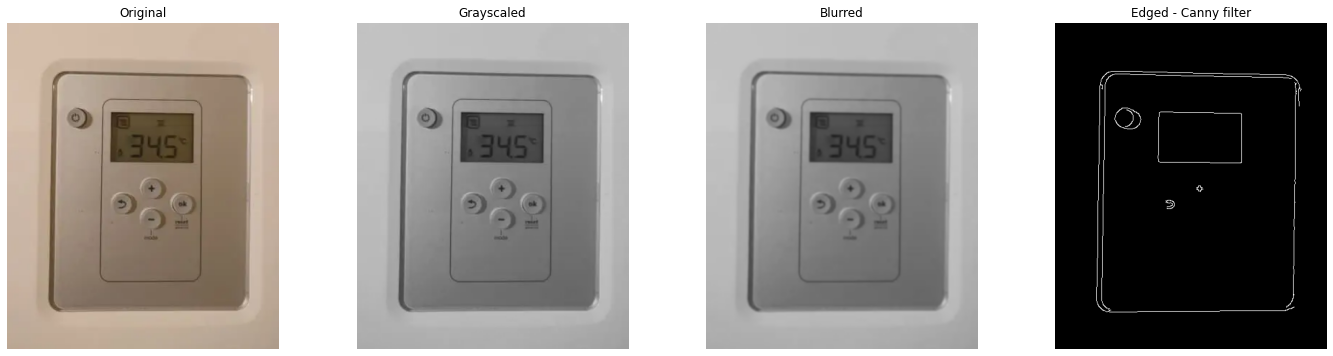

In [22]:
imgs = []
names = []
# load the example image
image = cv2.imread("input/03.png")
imgs.append(image); names.append('Original')
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
imgs.append(gray); names.append('Grayscaled')
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
imgs.append(blurred); names.append('Blurred')
edged = cv2.Canny(blurred, 50, 200, 255)
imgs.append(edged); names.append('Edged - Canny filter')
plot_steps(imgs, names, cols = 4)

[[[159 138]]

 [[158 213]]

 [[285 214]]

 [[285 140]]]


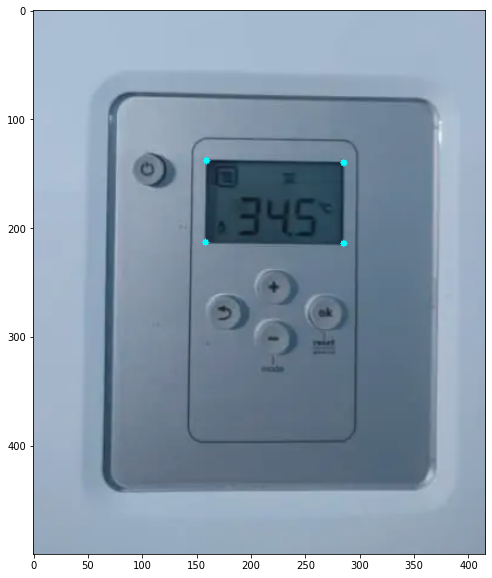

In [30]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
	# if the contour has four vertices, then we have found the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break
if not(displayCnt is None):
    img = image.copy()
    cv2.drawContours(img, displayCnt, -1, (0, 255, 255), 5)
    plt.imshow(img)
    print(displayCnt)

3
4
5


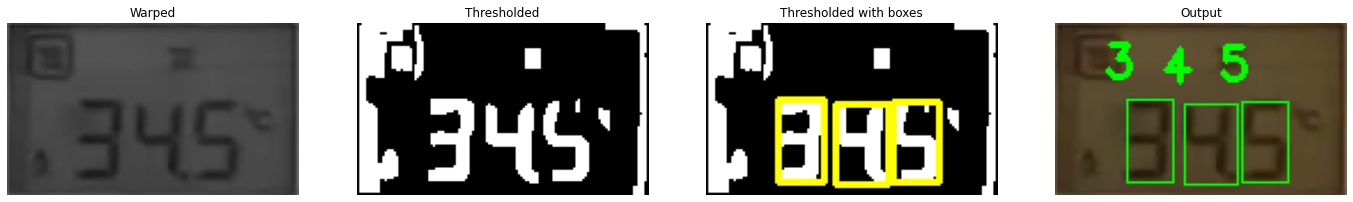

In [77]:
imgs = []; names = []
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
imgs.append(warped); names.append('Warped')
output = four_point_transform(image, displayCnt.reshape(4, 2))

thresh = cv2.threshold(warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
imgs.append(thresh); names.append('Thresholded')

# find contours in the thresholded image, then initialize the
# digit contours lists
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
for c in cnts:
	# compute the bounding box of the contour
	(x, y, w, h) = cv2.boundingRect(c)
	# if the contour is sufficiently large, it must be a digit
	if w >= 15 and (h >= 30 and h <= 40):
		digitCnts.append(c)
        
# sort the contours from left-to-right, then initialize the
# actual digits themselves
digitCnts = contours.sort_contours(digitCnts,
	method="left-to-right")[0]
digits = []

thresh_box = thresh.copy()
thresh_box = cv2.cvtColor(thresh_box, cv2.COLOR_GRAY2BGR)
# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
	(x, y, w, h) = cv2.boundingRect(c)
    
	cv2.rectangle(thresh_box,(x,y),(x+w,y+h),(0,255,255),2)
    
	roi = thresh[y:y + h, x:x + w]
	# compute the width and height of each of the 7 segments
	# we are going to examine
	(roiH, roiW) = roi.shape
	(dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
	dHC = int(roiH * 0.05)
	# define the set of 7 segments
	segments = [
		((0, 0), (w, dH)),	# top
		((0, 0), (dW, h // 2)),	# top-left
		((w - dW, 0), (w, h // 2)),	# top-right
		((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
		((0, h // 2), (dW, h)),	# bottom-left
		((w - dW, h // 2), (w, h)),	# bottom-right
		((0, h - dH), (w, h))	# bottom
	]
	on = [0] * len(segments)
	# loop over the segments
	for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
		# extract the segment ROI, count the total number of
		# thresholded pixels in the segment, and then compute
		# the area of the segment
		segROI = roi[yA:yB, xA:xB]
		total = cv2.countNonZero(segROI)
		area = (xB - xA) * (yB - yA)
		# if the total number of non-zero pixels is greater than
		# 50% of the area, mark the segment as "on"
		if total / float(area) > 0.5:
			on[i]= 1
	# lookup the digit and draw it on the image
	digit = DIGITS_LOOKUP[tuple(on)]
	print(digit)
	digits.append(digit)
	cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 1)
	cv2.putText(output, str(digit), (x - 10, y - 10),
		cv2.FONT_HERSHEY_SIMPLEX, 0.65, (0, 255, 0), 2)

    
imgs.append(thresh_box); names.append('Thresholded with boxes')
imgs.append(output); names.append('Output')
plot_steps(imgs, names, cols = 4)

# Credit Card solution

In [78]:
# import the necessary packages
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2

Next steps:
- copy thermostat solution, convert them into lab
- think about similar solution for some devices (cars plate, doors number, oven numbers)